In [1]:
from __future__ import print_function, division
import sys
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data Downloads

In [2]:
PUIdata = os.getenv('PUIDATA')
print(PUIdata)

/home/cusp/uc288/PUIdata


### Data: Manhattan PLUTO information
Source: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

Download link: https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip

*This download is a zip file of the PLUTO dataset for all NYC boroughs, but for this homework, I will only use the Manhattan data.*

In [3]:
if not os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
    print('Downloading...')
    os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip')
    os.system('mv nyc_pluto_16v2%20.zip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/nyc_pluto_16v2%20.zip -d ' + PUIdata)
    if os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


### Data: LL84 Report for 2013
Source: https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z

Download link (retrieved from API): https://data.cityofnewyork.us/resource/m46j-75iy.csv

In [4]:
url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
filename = 'LL84_2013.csv'

if not os.path.isfile(PUIdata + '/' + filename):
    print('Downloading...')
    os.system('curl -o ' + filename + ' ' + url)
    os.system('mv ' + filename + ' ' + PUIdata)
    if os.path.isfile(PUIdata + '/' + filename):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


## Data Cleaning and Munging

In [5]:
mn_bbl = pd.read_csv(PUIdata + '/BORO_zip_files_csv/MN.csv')
mn_bbl.columns

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'

In [6]:
mn_bbl = mn_bbl[['BBL', 'UnitsRes', 'UnitsTotal', 'YearBuilt']]
mn_bbl.head()

,BBL,UnitsRes,UnitsTotal,YearBuilt
0,1.000010e+09,0,0,1900
1,1.000010e+09,0,0,1900
2,1.000010e+09,0,0,1900
3,1.000010e+09,0,0,0
4,1.000010e+09,0,0,0


In [7]:
ll84 = pd.read_csv(PUIdata + '/LL84_2013.csv')
ll84.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BI

In [8]:
ll84_num = ll84[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)', 
                 'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'DOF Number of Buildings', 'Postcode']]
ll84_num.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,Postcode
0,1.000410e+09,NaN,918919,NaN,NaN,NaN
1,4.021460e+09,NaN,NaN,82730.0,1.0,11375.0
2,2.027620e+09,NaN,64200,NaN,NaN,NaN
3,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0
4,2.048300e+09,NaN,50000,NaN,NaN,NaN


In [9]:
ll84_num = ll84_num.rename(columns={'Site EUI(kBtu/ft2)': 'SiteEui',
                                    'DOF Property Floor Area (Buildngs and Parking)(ft2)': 'DOFArea', 
                                    'DOF Number of Buildings': 'DOFNumBldg', 
                                    'Reported Property Floor Area (Building(s)) (ft²)': 'ReportedArea'})

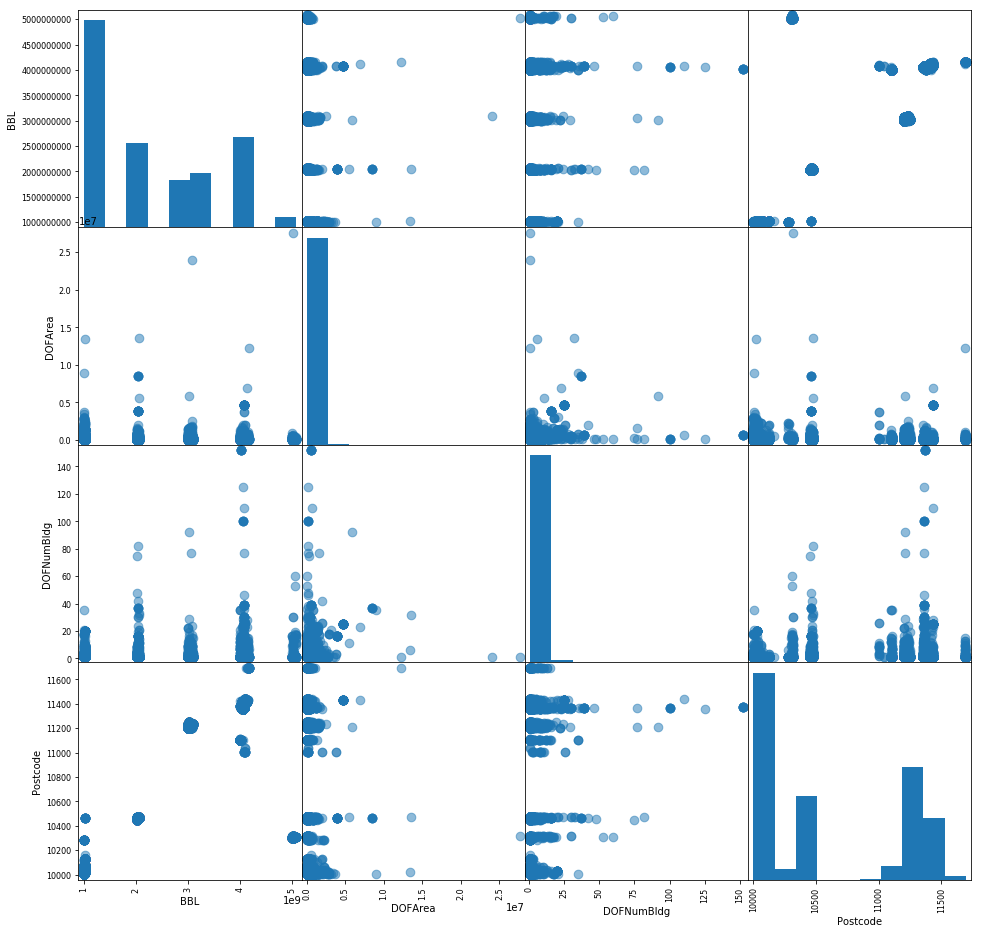

In [10]:
scatter_matrix(ll84_num, s=300, figsize=(16,16));

### Figure 1. TODO!!!!!!

In [11]:
ll84_num.SiteEui = pd.to_numeric(ll84_num.SiteEui, errors='coerce')
count = np.isnan(ll84_num.SiteEui).sum()
print ("invalid entries changed to NaN %d"%sum(count))

invalid entries changed to NaN 4623


### Merge Datasets

In [12]:
df = ll84_num.merge(mn_bbl, on='BBL')

In [13]:
df.head()

,BBL,SiteEui,ReportedArea,DOFArea,DOFNumBldg,Postcode,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,1.0,10009.0,0,4,1920
2,1.013110e+09,125.4,330000,313200.0,1.0,10022.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,1.0,10003.0,148,148,1963
4,1.007400e+09,NaN,68329,NaN,NaN,NaN,0,1,1920


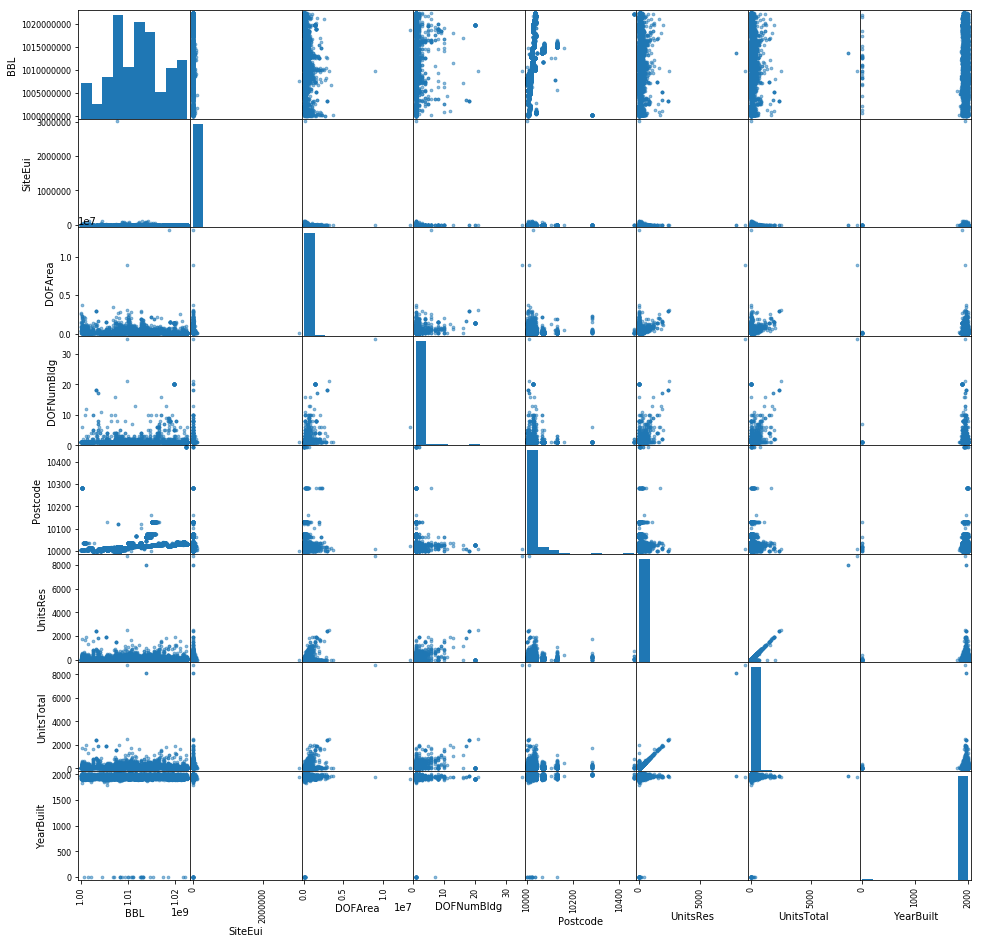

In [14]:
scatter_matrix(df, s=30, figsize=(16, 16));

### Figure 2.

In [15]:
df['EnergyCons'] = df.SiteEui * df.DOFArea
df.head()

,BBL,SiteEui,ReportedArea,DOFArea,DOFNumBldg,Postcode,UnitsRes,UnitsTotal,YearBuilt,EnergyCons
0,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0,0,1,1987,NaN
1,1.004370e+09,NaN,NaN,52390.0,1.0,10009.0,0,4,1920,NaN
2,1.013110e+09,125.4,330000,313200.0,1.0,10022.0,0,56,1977,39275280.0
3,1.009220e+09,NaN,NaN,98260.0,1.0,10003.0,148,148,1963,NaN
4,1.007400e+09,NaN,68329,NaN,NaN,NaN,0,1,1920,NaN


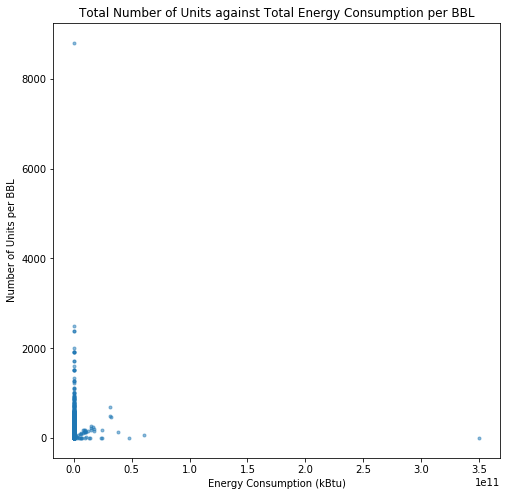

In [16]:
fig = pl.figure(figsize(8,8))
ax = fig.add_subplot(111)
ax.plot(df.EnergyCons, df.UnitsTotal, '.', alpha=0.5)
ax.set_title('Total Number of Units against Total Energy Consumption per BBL')
ax.set_xlabel('Energy Consumption (kBtu)')
ax.set_ylabel('Number of Units per BBL');

### Figure 3. Total number of units in a BBL against the Total Energy Consumption (kBtu)

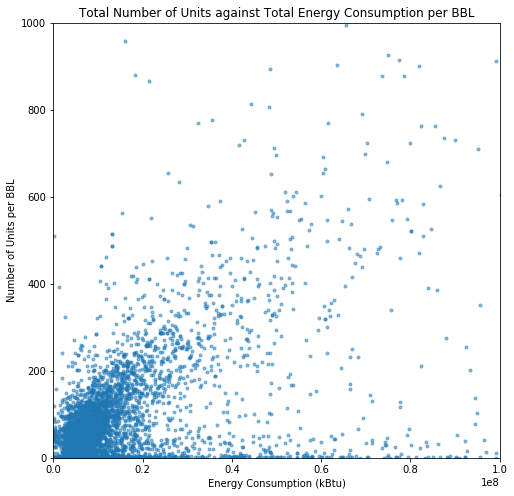

In [17]:
fig = pl.figure(figsize(8,8))
ax = fig.add_subplot(111)
ax.plot(df.EnergyCons, df.UnitsTotal, '.', alpha=0.5)
ax.set_xlim(1000,1e8)
ax.set_ylim(0,1000)
ax.set_title('Total Number of Units against Total Energy Consumption per BBL')
ax.set_xlabel('Energy Consumption (kBtu)')
ax.set_ylabel('Number of Units per BBL');

### Figure 4. Zoomed in section of Figure 3.

In [18]:
len(df)

6536

In [19]:
df.dropna(inplace=True)

In [20]:
len(df)

4707

In [21]:
df.head()

,BBL,SiteEui,ReportedArea,DOFArea,DOFNumBldg,Postcode,UnitsRes,UnitsTotal,YearBuilt,EnergyCons
2,1.013110e+09,125.4,330000,313200.0,1.0,10022.0,0,56,1977,39275280.0
15,1.007660e+09,122.3,59468,53168.0,1.0,10011.0,0,8,1912,6502446.4
16,1.008150e+09,117.0,364000,364000.0,1.0,10018.0,0,24,1954,42588000.0
18,1.005050e+09,82.1,235370,214110.0,1.0,10013.0,0,24,1926,17578431.0
19,1.021420e+09,137.7,64806,64816.0,1.0,10032.0,54,62,1924,8925163.2


In [22]:
df_cut = df[(df.UnitsTotal >= 10) & (df.UnitsTotal < 1000) & (df.EnergyCons > 1000)]
len(df_cut)

4010

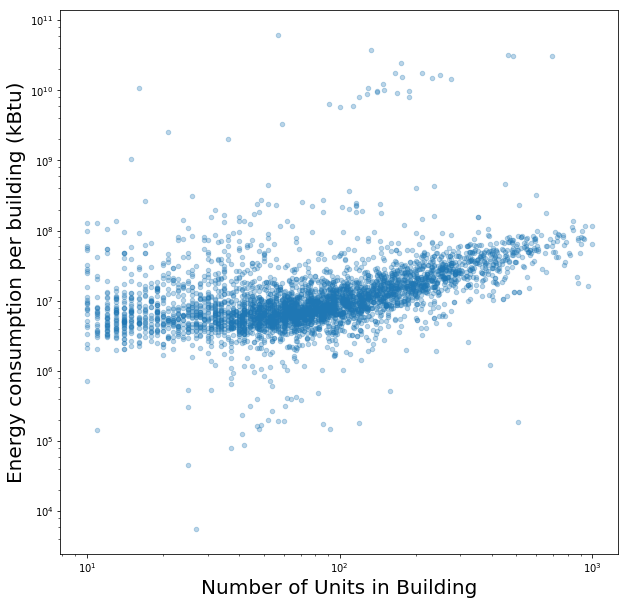

In [ ]:
ax = df_cut.plot(kind='scatter', y='EnergyCons', x='UnitsTotal', 
                   marker='o',  figsize=(10, 10), loglog=True, alpha=0.3)
x1 = ax.set_xlabel("Number of Units in Building", fontsize=20)
y1 = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

In [ ]:
x = df.UnitsTotal
y = df.EnergyCons

X = sm.add_constant(np.log10(x))

lm = sm.OLS(np.log10(y), X, missing='drop').fit()
lm.summary()

In [ ]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.log10(df.UnitsTotal), np.log10(df.EnergyCons), 'o', alpha=0.3)
ax.plot(np.log10(df.UnitsTotal), lm.predict(sm.add_constant(np.log10(df.UnitsTotal))), '-')
ax.set_xlabel("Number of Units in Building", fontsize=20)
ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)